In [334]:
!poetry env use 3.12
!poetry env activate

Using virtualenv: C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12
"C:\Users\04n\AppData\Local\pypoetry\Cache\virtualenvs\corn-leaf-disease-classifier-davY0eoL-py3.12\Scripts\activate.bat"


In [335]:
!poetry install
!poetry lock
#!poetry run pip freeze
    # ipykernel
    # keras
    # matplotlib
    # numpy
    # ruff
    # seaborn
    # tensorflow

Installing dependencies from lock file

No dependencies to install or update
Resolving dependencies...


# Set Seed

In [336]:
import os

In [337]:
SEED = 727

In [338]:
os.environ['PYTHONHASHSEED'] = str(SEED)

# Setup Imports

In [339]:
import keras
import matplotlib.figure
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf

# import warnings
import warnings
# filter warnings
warnings.filterwarnings('ignore')

In [340]:
from numpy._typing._array_like import NDArray
import os
from pathlib import Path
from PIL import Image, ImageEnhance
from typing import Any
import random

IMAGE_SIZE: tuple[int, int] = (64, 64)
IMAGE_SUFFIXES: set[str] = {'.jpeg', '.jpg', '.png'}

# Load Datasets

In [341]:
ROOT_PATH: Path = Path.cwd().parent
TRAIN_PATH: Path = ROOT_PATH / 'data' / 'train'
TEST_PATH: Path = ROOT_PATH / 'data' / 'test'

TRAIN_CHECKPOINT_PATH: Path = ROOT_PATH / 'cnn' / 'checkpoints'

In [342]:
def load_image_from_path(image_path: Path) -> list[int]:
    image: Image.Image = Image.open(image_path).convert('RGB').resize((64,64))
    image = ImageEnhance.Color(image).enhance(2.0)

    image_flat: NDArray[Any] = np.asarray(image, dtype="int64").flatten()

    ret: list[int] = [int(i) for i in image_flat]
    return ret

In [343]:
def get_dataset_classes(dataset_path: Path) -> list[str]:
    return [d.name for d in dataset_path.iterdir() if d.is_dir()]

In [344]:
def load_dataset_from_directory(dataset_path: Path) -> pd.DataFrame:
    dataset_classes: list[str] = get_dataset_classes(dataset_path)

    labels: list[str] = ['label']
    for i in range(IMAGE_SIZE[0]):
        for j in range(IMAGE_SIZE[1]):
            for k in ['r', 'g', 'b']:
                labels.append(f'pixel{i*IMAGE_SIZE[0] + j}_{k}')

    data: dict[str, list[int]] = {}
    for label in labels:
        data[label] = []
    for d_c, dataset_class in enumerate(dataset_classes):
        for image_path in (dataset_path / dataset_class).iterdir():
            if not image_path.is_file() or image_path.suffix not in IMAGE_SUFFIXES:
                continue

            row: list[int] = []
            row.append(d_c)
            row.extend(load_image_from_path(image_path))

            for i in range(len(labels)):
                data[labels[i]].append(row[i])

    ret: pd.DataFrame = pd.DataFrame(
        data=data,
        )

    return ret

In [345]:
train: pd.DataFrame = load_dataset_from_directory(TRAIN_PATH)
print(train.shape)
train.head()

(3350, 12289)


,label,pixel0_r,pixel0_g,pixel0_b,pixel1_r,pixel1_g,pixel1_b,pixel2_r,pixel2_g,pixel2_b,...,pixel4092_b,pixel4093_r,pixel4093_g,pixel4093_b,pixel4094_r,pixel4094_g,pixel4094_b,pixel4095_r,pixel4095_g,pixel4095_b
0,0,136,152,190,139,155,193,133,149,185,...,121,255,194,116,255,193,115,254,188,106
1,0,119,101,143,118,100,142,118,100,142,...,187,197,175,187,196,174,186,193,171,183
2,0,161,155,141,165,177,185,118,104,106,...,76,103,71,59,96,68,62,75,55,55
3,0,117,149,0,121,137,0,88,114,0,...,0,39,105,0,39,103,0,45,105,0
4,0,33,57,91,82,104,68,175,191,97,...,63,246,100,60,255,112,58,255,121,57


In [346]:
'''
test: pd.DataFrame = load_dataset_from_directory(TEST_PATH)
print(test.shape)
#test.head()
'''

'\ntest: pd.DataFrame = load_dataset_from_directory(TEST_PATH)\nprint(test.shape)\n#test.head()\n'

# Reset Seed

- if only tweaking model parameters (after already running the entire notebook once), then just **Execute Cell and Below** from here (no need to reload entire dataset)

In [396]:
def set_seeds(seed: int) -> None:
    os.environ['PYTHONHASHSEED'] = str(seed)
    keras.utils.set_random_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

In [397]:
set_seeds(SEED)

# Create DataFrames

In [398]:
Y_train: pd.Series = train['label']
X_train: pd.DataFrame = train.drop(
    labels = ['label'],
    axis = 1
    ) 
Y_train.value_counts()

label
1    1045
3     929
0     917
2     459
Name: count, dtype: int64

# Normalization, Reshape and Label Encoding 

In [399]:
NUM_CLASSES: int = len(get_dataset_classes(TRAIN_PATH))
NUM_CLASSES

4

In [400]:
# normalize train data
X_train /= 255.0
X_train *= X_train
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 12288)


In [401]:
'''
test /= 255.0
print("test shape: ", test.shape)
'''

'\ntest /= 255.0\nprint("test shape: ", test.shape)\n'

In [402]:
# reshape, supports shape inference using `-1` as dimension
X_train: pd.DataFrame = X_train.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("X_train shape: ", X_train.shape)

X_train shape:  (3350, 64, 64, 3)


In [403]:
'''
test = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
print("test shape: ", test.shape)
'''

'\ntest = test.values.reshape(-1, IMAGE_SIZE[0], IMAGE_SIZE[1], 3)\nprint("test shape: ", test.shape)\n'

In [404]:
# Label Encoding 
from keras.utils import to_categorical # convert to one-hot-encoding

Y_train: NDArray[np.float64] = to_categorical(Y_train, num_classes=NUM_CLASSES)

# Train Test Split

In [405]:
from sklearn.model_selection import train_test_split

TEST_SIZE = 0.2

In [406]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=TEST_SIZE, random_state=SEED)
print("x_train shape", X_train.shape)
print("x_test shape", X_val.shape)
print("y_train shape", Y_train.shape)
print("y_test shape", Y_val.shape)

x_train shape (2680, 64, 64, 3)
x_test shape (670, 64, 64, 3)
y_train shape (2680, 4)
y_test shape (670, 4)


# CNN

In [407]:
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop, Adam
#from keras.preprocessing.image import ImageDataGenerator
from keras.src.legacy.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint

In [408]:
# optimizer, loss, etrics
OPTIMIZER = Adam(
    learning_rate = 0.001,
    beta_1 = 0.9,
    beta_2 = 0.99
    )
LOSS: str = 'categorical_crossentropy'
METRICS: list[str] = ['accuracy', 'f1_score', 'precision', 'recall']

# epochs, batch size
EPOCHS = 80
BATCH_SIZE = 50

In [409]:
# CNN model layers
model = Sequential()

#
model.add(Conv2D(
    filters = 8,
    kernel_size = (5,5),
    padding = 'Same', 
    activation ='relu',
    input_shape = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
    ))
model.add(MaxPool2D(
    pool_size = (3,3)
    ))
model.add(Dropout(0.25))

#
model.add(Conv2D(
    filters = 16,
    kernel_size = (3,3),
    padding = 'Same', 
    activation ='relu'))
model.add(MaxPool2D(
    pool_size = (3,3),
    strides = (2,2)
    ))
model.add(Dropout(0.4))

# fully connected
model.add(Flatten())
model.add(Dense(1024, activation = "relu"))
model.add(Dropout(0.25))
model.add(Dense(NUM_CLASSES, activation = "softmax"))

In [410]:
# compile the model
model.compile(
    optimizer=OPTIMIZER,
    loss=LOSS,
    metrics=METRICS
    )

In [411]:
# data augmentation
datagen = ImageDataGenerator(
        featurewise_center = False,  # set input mean to 0 over the dataset
        samplewise_center = False,  # set each sample mean to 0
        featurewise_std_normalization = False,  # divide inputs by std of the dataset
        samplewise_std_normalization = False,  # divide each input by its std
        zca_whitening = False,  # dimemsion reduction
        rotation_range = 90,  # randomly rotate images in the range 20 degrees
        zoom_range = 0.05, # Randomly zoom image 5%
        width_shift_range = 0.1,  # randomly shift images horizontally 10%
        height_shift_range = 0.1,  # randomly shift images vertically 10%
        horizontal_flip = True,  # randomly flip images
        vertical_flip = True)  # randomly flip images

datagen.fit(
    X_train,
    seed=SEED
    )

In [412]:
# model callbacks
model_checkpoint = ModelCheckpoint(
    filepath = TRAIN_CHECKPOINT_PATH / 'checkpoint_{epoch:02d}-{val_loss:.4f}.weights.h5', 
    verbose = 0,
    save_best_only = True,
    save_weights_only = True,
    save_freq = 'epoch'
    )

In [413]:
# fit the model
history = model.fit(
    datagen.flow(
        X_train, Y_train,
        batch_size = BATCH_SIZE
    ),
    epochs = EPOCHS,
    validation_data = (X_val, Y_val),
    steps_per_epoch = X_train.shape[0] // BATCH_SIZE,
    callbacks = [model_checkpoint],
    )

Epoch 1/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - accuracy: 0.4622 - f1_score: 0.3961 - loss: 1.3603 - precision: 0.5634 - recall: 0.2200 - val_accuracy: 0.6851 - val_f1_score: 0.5454 - val_loss: 0.7584 - val_precision: 0.7700 - val_recall: 0.6045
Epoch 2/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7600 - f1_score: 0.5836 - loss: 0.6438 - precision: 0.8182 - recall: 0.7200 - val_accuracy: 0.7000 - val_f1_score: 0.5586 - val_loss: 0.7410 - val_precision: 0.7868 - val_recall: 0.6060
Epoch 3/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - accuracy: 0.7740 - f1_score: 0.6702 - loss: 0.5638 - precision: 0.8327 - recall: 0.7176 - val_accuracy: 0.7985 - val_f1_score: 0.7440 - val_loss: 0.5772 - val_precision: 0.8779 - val_recall: 0.6866
Epoch 4/80
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - f1_score: 0.6679 - loss: 0.4942 - precision: 0.8182 - recall: 0.7200 - val_accuracy: 0.8090 - val_f1_score: 0.7647 - val_loss: 0.5654 - val_precision: 0.8797 - val_recall: 0.698

# History Curves

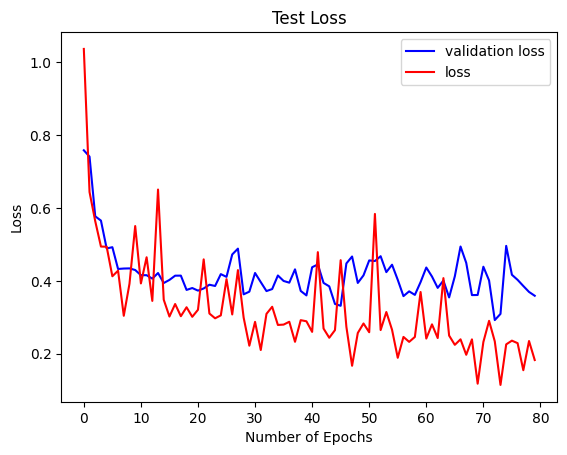

In [414]:
# Plot the loss curves for training and validation 
plt.plot(
    history.history['val_loss'],
    color='b',
    label="validation loss"
    )
plt.plot(
    history.history['loss'],
    color='r',
    label="loss"
    )

# set plot title and axis labels
plt.title("Test Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

# show plot
plt.show()

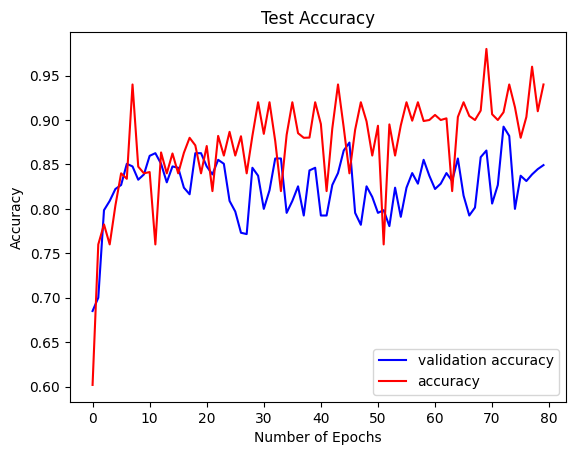

In [415]:
# Plot the accuracy curves for training and validation
if 'accuracy' in METRICS:
    plt.plot(
        history.history['val_accuracy'],
        color='b',
        label="validation accuracy"
        )
    plt.plot(
        history.history['accuracy'],
        color='r',
        label="accuracy"
        )

    # set plot title and axis labels
    plt.title("Test Accuracy")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # show plot
    plt.show()

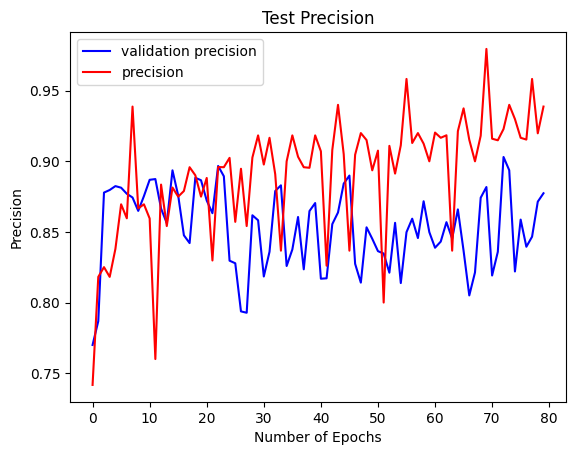

In [416]:
# Plot the precision curves for training and validation 
if 'precision' in METRICS:
    plt.plot(
        history.history['val_precision'],
        color='b',
        label="validation precision"
        )
    plt.plot(
        history.history['precision'],
        color='r',
        label="precision"
        )

    # set plot title and axis labels
    plt.title("Test Precision")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Precision")
    plt.legend()

    # show plot
    plt.show()

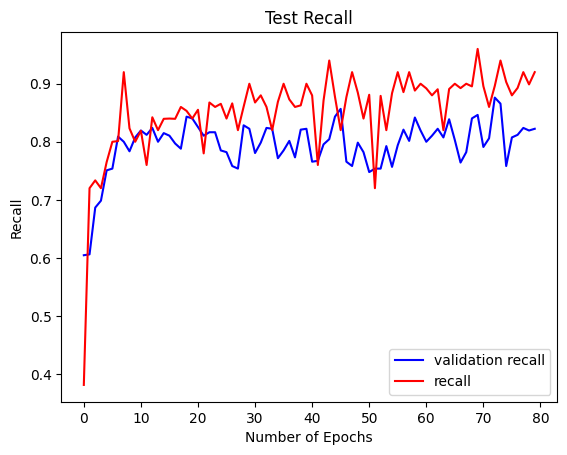

In [417]:
# Plot the recall curves for training and validation
if 'recall' in METRICS:
    plt.plot(
        history.history['val_recall'],
        color='b',
        label="validation recall"
        )
    plt.plot(
        history.history['recall'],
        color='r',
        label="recall"
        )

    # set plot title and axis labels
    plt.title("Test Recall")
    plt.xlabel("Number of Epochs")
    plt.ylabel("Recall")
    plt.legend()

    # show plot
    plt.show()

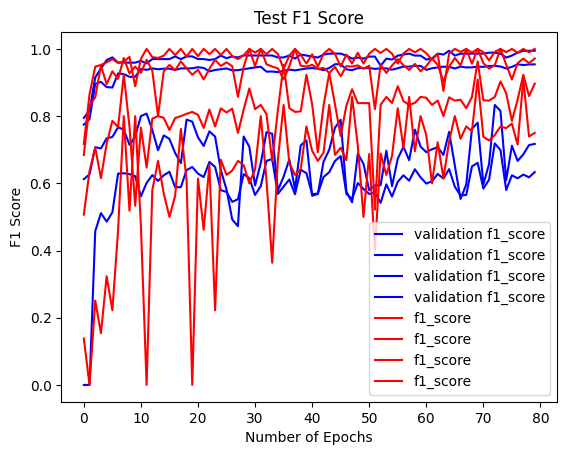

In [418]:
# Plot the F1 score curves for training and validation
if 'f1_score' in METRICS:
    plt.plot(
        history.history['val_f1_score'],
        color='b',
        label="validation f1_score"
        )
    plt.plot(
        history.history['f1_score'],
        color='r',
        label="f1_score"
        )

    # set plot title and axis labels
    plt.title("Test F1 Score")
    plt.xlabel("Number of Epochs")
    plt.ylabel("F1 Score")
    plt.legend()

    # show plot
    plt.show()

# Confusion Matrix

In [419]:
# load best saved weights into model
for checkpoint_path in TRAIN_CHECKPOINT_PATH.iterdir():
    model.load_weights(checkpoint_path)

21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


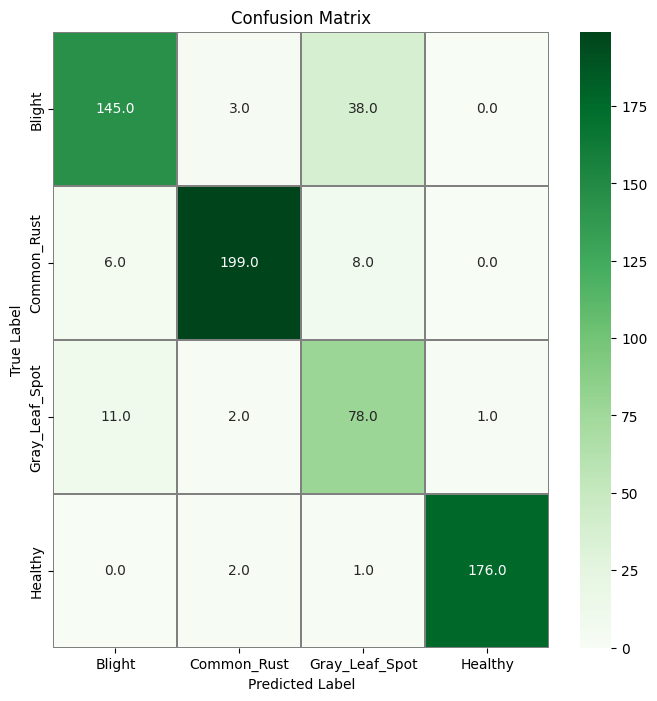

In [420]:
# confusion matrix

# Predict the values from the validation dataset
from numpy import ndarray

Y_pred = model.predict(X_val)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 

# compute the confusion matrix
confusion_mtx: ndarray[Any, Any] = confusion_matrix(Y_true, Y_pred_classes) 

# plot the confusion matrix
f: matplotlib.figure.Figure; ax: plt.Axes
f, ax = plt.subplots(figsize=(8, 8))

# generate confusion matrix as heatmap
sns.heatmap(
    confusion_mtx,
    annot=True,
    linewidths=0.01,
    cmap="Greens",
    linecolor="gray",
    fmt='.1f',
    ax=ax,
    xticklabels=get_dataset_classes(TRAIN_PATH),
    yticklabels=get_dataset_classes(TRAIN_PATH),
    )

# set title and axis labels of confusion matrix
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# show confusion matrix
plt.show()

In [421]:
confusion_mtx

array([[145,   3,  38,   0],
       [  6, 199,   8,   0],
       [ 11,   2,  78,   1],
       [  0,   2,   1, 176]])

# Generate Prediction CSV

In [422]:
CSV_FILENAME = 'predictions.csv'

In [423]:
test_image_paths: list[Path] = [image_path for image_path in TEST_PATH.iterdir() if image_path.is_file() and image_path.suffix in IMAGE_SUFFIXES]
test_images: list[list[int]] = [load_image_from_path(image_path) for image_path in test_image_paths]

In [424]:
test: NDArray[Any] = np.array([
    np.array(test_image).reshape(IMAGE_SIZE[0], IMAGE_SIZE[1], 3) for test_image in test_images
    ])

In [425]:
test_pred = model.predict(test)
test_pred_classes = np.argmax(test_pred, axis = 1) 
test_predictions = [get_dataset_classes(TRAIN_PATH)[i] for i in test_pred_classes]

27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [426]:
CSV_PATH: Path = Path.cwd() / CSV_FILENAME

csv_lines: list[tuple[Path, str]] = [(image_path, str(prediction)) for image_path, prediction in zip(test_image_paths, test_predictions)]
csv_lines.sort(key=lambda l : int(l[0].stem))

csv_lines_str: list[str] = [f'{l[0].name},{l[1]}' for l in csv_lines]

with open(CSV_PATH, 'w') as csv_file:
    csv_file.write('\n'.join(csv_lines_str))

csv_lines_str

['0.jpeg,Healthy',
 '1.jpeg,Healthy',
 '2.jpeg,Healthy',
 '3.jpeg,Healthy',
 '4.jpeg,Healthy',
 '5.jpeg,Healthy',
 '6.jpeg,Healthy',
 '7.jpeg,Healthy',
 '8.jpeg,Healthy',
 '9.jpeg,Healthy',
 '10.jpeg,Healthy',
 '11.jpeg,Healthy',
 '12.jpeg,Healthy',
 '13.jpeg,Healthy',
 '14.jpeg,Healthy',
 '15.jpeg,Healthy',
 '16.jpeg,Healthy',
 '17.jpeg,Healthy',
 '18.jpeg,Healthy',
 '19.jpeg,Healthy',
 '20.jpeg,Healthy',
 '21.jpeg,Healthy',
 '22.jpeg,Healthy',
 '23.jpeg,Healthy',
 '24.jpeg,Healthy',
 '25.jpeg,Healthy',
 '26.jpeg,Healthy',
 '27.jpeg,Healthy',
 '28.jpeg,Healthy',
 '29.jpeg,Healthy',
 '30.jpeg,Healthy',
 '31.jpeg,Healthy',
 '32.jpeg,Healthy',
 '33.jpeg,Healthy',
 '34.jpeg,Healthy',
 '35.jpeg,Healthy',
 '36.jpeg,Healthy',
 '37.jpeg,Healthy',
 '38.jpeg,Healthy',
 '39.jpeg,Healthy',
 '40.jpeg,Healthy',
 '41.jpeg,Healthy',
 '42.jpeg,Healthy',
 '43.jpeg,Healthy',
 '44.jpeg,Healthy',
 '45.jpeg,Healthy',
 '46.jpeg,Healthy',
 '47.jpeg,Healthy',
 '48.jpeg,Healthy',
 '49.jpeg,Healthy',
 '50.jpeg,